In [1]:
import pandas as pd
import backtrader as bt
# import matplotlib.pyplot as plt
# import tushare as ts
import datetime
%matplotlib inline

d:\Anaconda3.1\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


## 导入ETF数据

In [2]:
import pickle
file2 = open('dataframes3.pkl', 'rb')
kdata = pickle.load(file2)
print(kdata)

{'159613':              open   high    low  close      volume  openinterest  is_last_day  \
date                                                                            
2014-01-27  0.000  0.000  0.000  0.000         0.0           0.0            0   
2014-01-28  0.000  0.000  0.000  0.000         0.0           0.0            0   
2014-01-29  0.000  0.000  0.000  0.000         0.0           0.0            0   
2014-01-30  0.000  0.000  0.000  0.000         0.0           0.0            1   
2014-02-07  0.000  0.000  0.000  0.000         0.0           0.0            0   
...           ...    ...    ...    ...         ...           ...          ...   
2023-04-24  0.990  0.999  0.977  0.984  14483100.0           0.0            0   
2023-04-25  0.983  0.994  0.965  0.981  17971302.0           0.0            0   
2023-04-26  0.978  0.980  0.930  0.941  14217300.0           0.0            0   
2023-04-27  0.931  0.944  0.910  0.918  13151902.0           0.0            0   
2023-04-28  0.931

In [3]:
for key,value in kdata.items():
    value = value.drop(labels='end_day', axis=1)
    for col in value.columns:
        value[col] = value[col].astype('float')
    value.index = pd.to_datetime(value.index)

    kdata[key] = value
    # break


In [4]:
kdata['gold']

,open,high,low,close,volume,openinterest,is_last_day,signal,weight
date,,,,,,,,,
2014-01-27,247.78,247.78,247.78,247.78,10000000.0,0.0,0.0,0.0,0.0
2014-01-28,245.90,245.90,245.90,245.90,10000000.0,0.0,0.0,0.0,0.0
2014-01-29,245.94,245.94,245.94,245.94,10000000.0,0.0,0.0,0.0,0.0
2014-01-30,246.37,246.37,246.37,246.37,10000000.0,0.0,1.0,0.0,0.0
2014-02-07,248.29,248.29,248.29,248.29,10000000.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2023-04-24,441.64,441.64,441.64,441.64,10000000.0,0.0,0.0,0.0,0.0
2023-04-25,445.44,445.44,445.44,445.44,10000000.0,0.0,0.0,0.0,0.0
2023-04-26,445.93,445.93,445.93,445.93,10000000.0,0.0,0.0,0.0,0.0


In [5]:
from backtrader.feeds import PandasData
class PandasData_Extend(PandasData):
    #这一列是其他要导入的数据
    lines = ('is_last_day','signal', 'weight') 
    params = (
        ('is_last_day', 6),
        ('signal', 7),
        ('weight', 8),  
    )    

## 策略具体代码：

In [6]:
class MonthlyRookieFOF(bt.Strategy):
    def __init__(self):
        pass
        
    def prenext(self):
        pass
    
        
    def downcast(self, amount, lot):
        #得到实际应该买股票的钱
        return abs(amount//lot*lot)
    
    #输出当前持仓情况
    def Hold_data(self):
        for i, d in enumerate(self.datas):
            pos = self.getposition(d)
            if pos.size>0:
                #从操作当天收盘的时间点分析：盈亏不算佣金
                print('{}, 持仓数量:{}, 成本价:{}, 操作当天的收盘价:{}, 盈亏:{:.2f}'.format(d._name, pos.size, pos.price, pos.adjbase, pos.size * (pos.adjbase - pos.price)))
    
    def next(self):    
        
        # 回测最后一天不进行买卖
        if self.datas[0].datetime.date(0) == end_date:
            print('截止了！！！！！！')
            return 
              
        
        #————————————————————————————————————————————————交易策略，每月一次操作——————————————————————————————————————————————————————————————————————————
        data_bench = self.getdatabyname('159613')
        trade_day = data_bench.is_last_day[0]
        
        if trade_day!=1:  
            # self.log('今日不交易！')
            return
        else:
            self.log('今日交易！') 
            self.Hold_data()
            #——————————————————————————————————————————————策略主体——————————————————————————————————————————————  
            target_list=[]
            weights = []
            buylist = []
            for symbol in self.getdatanames():
                data = self.getdatabyname(symbol)
                signal = data.signal[0]
                weight = data.weight[0]
                if signal == 1:
                    target_list.append(symbol)
                    weights.append(weight)
            # print(target_list)

            # 获取当前持仓仓位
            pos = dict()
            for d in self.datas:
                pos[d._name] = self.getposition(d).size
            # 计算调仓前的仓位
            for symbol in pos.keys():
                if symbol not in target_list:
                    self.sell(data=self.getdatabyname(symbol), size=pos[symbol])
            # 计算目标仓位
            target_pos = dict(zip(target_list, weights))
            # 计算调整仓位,先卖出操作
            for symbol in target_pos.keys():
                data = self.getdatabyname(symbol)
                target_amount = self.broker.getvalue()  * target_pos[symbol]
                target_size = target_amount // data.close[0]
                current_size = pos.get(symbol, 0)
                
                if target_size < current_size:                
                    self.sell(data=data, size=current_size - target_size,price=data.close[0])  
                elif target_size > current_size:
                    buylist.append(symbol)
            #再买入操作
            if buylist:
                for symbol in buylist:
                    data = self.getdatabyname(symbol)
                    target_amount = self.broker.getvalue()  * target_pos[symbol]
                    target_size = target_amount // data.close[0]
                    current_size = pos.get(symbol, 0)
                    self.buy(data=data, size=target_size - current_size,price=data.close[0])
                  
        
    def log(self, txt, dt=None):
        ''' 输出日志'''
        dt = dt or self.datas[0].datetime.date(0) #当天日期
        print('%s, %s' % (dt.isoformat(), txt))

        
    def stop(self):
        hold_list = [_p._name for _p in self.broker.positions if self.broker.getposition(_p).size > 0]
        self.log(f'回测结束情况：：：：：现金:{cerebro.broker.get_cash():.2f},总市值:{self.broker.getvalue():.2f}, 持仓情况:{[(x, self.getpositionbyname(x).size) for x in hold_list]}')                    

start_time = datetime.datetime.now()#计时
# 开始回测
cerebro = bt.Cerebro()

#基础模式
cerebro.addstrategy(MonthlyRookieFOF)   


startcash = 1e5
cerebro.broker.setcash(startcash)
print(f"初始资金{cerebro.broker.getvalue()}")

# 设置交易手续费
cerebro.broker.setcommission(0.0001)



start_date = datetime.date(2014,6,1)  
end_date = datetime.date(2023,2,28)  

for secu in kdata.keys():
    df = kdata[secu]
    data = PandasData_Extend(dataname=df, fromdate = start_date, todate = end_date)
    cerebro.adddata(data, name=secu)


# 加入指标
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='_pyfolio')

# 运行回测系统
results = cerebro.run()  
# 获取回测结束后的总资金
portvalue = cerebro.broker.getvalue()
# 打印结果
print(f'结束资金: {round(portvalue, 2)}')


end_time = datetime.datetime.now()
print('总运行时间：',end_time-start_time)

初始资金100000.0
2014-06-30, 今日交易！
2014-07-31, 今日交易！
159928, 持仓数量:9493.0, 成本价:0.912, 操作当天的收盘价:0.998, 盈亏:816.40
510170, 持仓数量:13367.0, 成本价:1.291, 操作当天的收盘价:1.46, 盈亏:2259.02
510230, 持仓数量:3494.0, 成本价:3.03, 操作当天的收盘价:3.397, 盈亏:1282.30
510410, 持仓数量:35094.0, 成本价:0.543, 操作当天的收盘价:0.617, 盈亏:2596.96
512010, 持仓数量:5070.0, 成本价:0.85, 操作当天的收盘价:0.881, 盈亏:157.17
bond1, 持仓数量:37.0, 成本价:206.76669999999996, 操作当天的收盘价:205.30831999999998, 盈亏:-53.96
bond2, 持仓数量:31.0, 成本价:229.63654, 操作当天的收盘价:230.11841999999996, 盈亏:14.94
oversees513500.SH, 持仓数量:9149.0, 成本价:1.091, 操作当天的收盘价:1.094, 盈亏:27.45
gold, 持仓数量:57.0, 成本价:263.99, 操作当天的收盘价:257.79, 盈亏:-353.40
2014-08-29, 今日交易！
159930, 持仓数量:11160.0, 成本价:0.852, 操作当天的收盘价:0.877, 盈亏:279.00
159936, 持仓数量:11357.0, 成本价:1.078, 操作当天的收盘价:1.105, 盈亏:306.64
510170, 持仓数量:7684.0, 成本价:1.291, 操作当天的收盘价:1.473, 盈亏:1398.49
510230, 持仓数量:4734.0, 成本价:3.125606252640473, 操作当天的收盘价:3.269, 盈亏:678.83
510410, 持仓数量:24259.0, 成本价:0.543, 操作当天的收盘价:0.624, 盈亏:1964.98
bond1, 持仓数量:38.0, 成本价:206.7302742105263, 操作当天的收盘价:206.174

In [7]:
import pyfolio as pf

d:\Anaconda3.1\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [8]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('_pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [9]:
returns

index
2014-06-03 00:00:00+00:00    0.000000
2014-06-04 00:00:00+00:00    0.000000
2014-06-05 00:00:00+00:00    0.000000
2014-06-06 00:00:00+00:00    0.000000
2014-06-09 00:00:00+00:00    0.000000
                               ...   
2023-02-22 00:00:00+00:00   -0.003878
2023-02-23 00:00:00+00:00   -0.003797
2023-02-24 00:00:00+00:00   -0.002210
2023-02-27 00:00:00+00:00   -0.005326
2023-02-28 00:00:00+00:00    0.006245
Name: return, Length: 2129, dtype: float64

In [10]:
positions

,gold,cash
Datetime,,
2014-06-03 00:00:00+00:00,0.00,100000.000000
2014-06-04 00:00:00+00:00,0.00,100000.000000
2014-06-05 00:00:00+00:00,0.00,100000.000000
2014-06-06 00:00:00+00:00,0.00,100000.000000
2014-06-09 00:00:00+00:00,0.00,100000.000000
...,...,...
2023-02-22 00:00:00+00:00,31464.00,3.915738
2023-02-23 00:00:00+00:00,31371.28,3.915738
2023-02-24 00:00:00+00:00,31464.76,3.915738


In [11]:
transactions.head(20)

,amount,price,sid,symbol,value
date,,,,,
2014-07-01 00:00:00+00:00,9493.0,0.91200,30,159928,-8657.61600
2014-07-01 00:00:00+00:00,13367.0,1.29100,41,510170,-17256.79700
2014-07-01 00:00:00+00:00,3494.0,3.03000,42,510230,-10586.82000
2014-07-01 00:00:00+00:00,35094.0,0.54300,43,510410,-19056.04200
2014-07-01 00:00:00+00:00,5070.0,0.85000,44,512010,-4309.50000
2014-07-01 00:00:00+00:00,37.0,206.76670,90,bond1,-7650.36790
2014-07-01 00:00:00+00:00,31.0,229.63654,91,bond2,-7118.73274
2014-07-01 00:00:00+00:00,9149.0,1.09100,92,oversees513500.SH,-9981.55900
2014-07-01 00:00:00+00:00,57.0,263.99000,93,gold,-15047.43000


Start date,2014-06-03
End date,2023-02-28
Total months,101
,Backtest
Annual return,9.4%
Cumulative returns,114.4%
Annual volatility,13.3%
Sharpe ratio,0.74
Calmar ratio,0.40
Stability,0.84
Max drawdown,-23.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.41,2021-09-07,2022-04-26,NaT,NaN
1,15.34,2015-05-28,2015-09-15,2016-03-18,212
2,13.22,2017-11-21,2018-09-17,2019-02-25,330
3,10.15,2015-01-05,2015-02-02,2015-04-27,81
4,9.09,2016-11-25,2017-01-03,2017-07-31,177


Stress Events,mean,min,max
Oct14,0.03%,-1.02%,1.19%
Fall2015,-0.22%,-2.09%,3.68%
New Normal,0.04%,-7.48%,6.98%


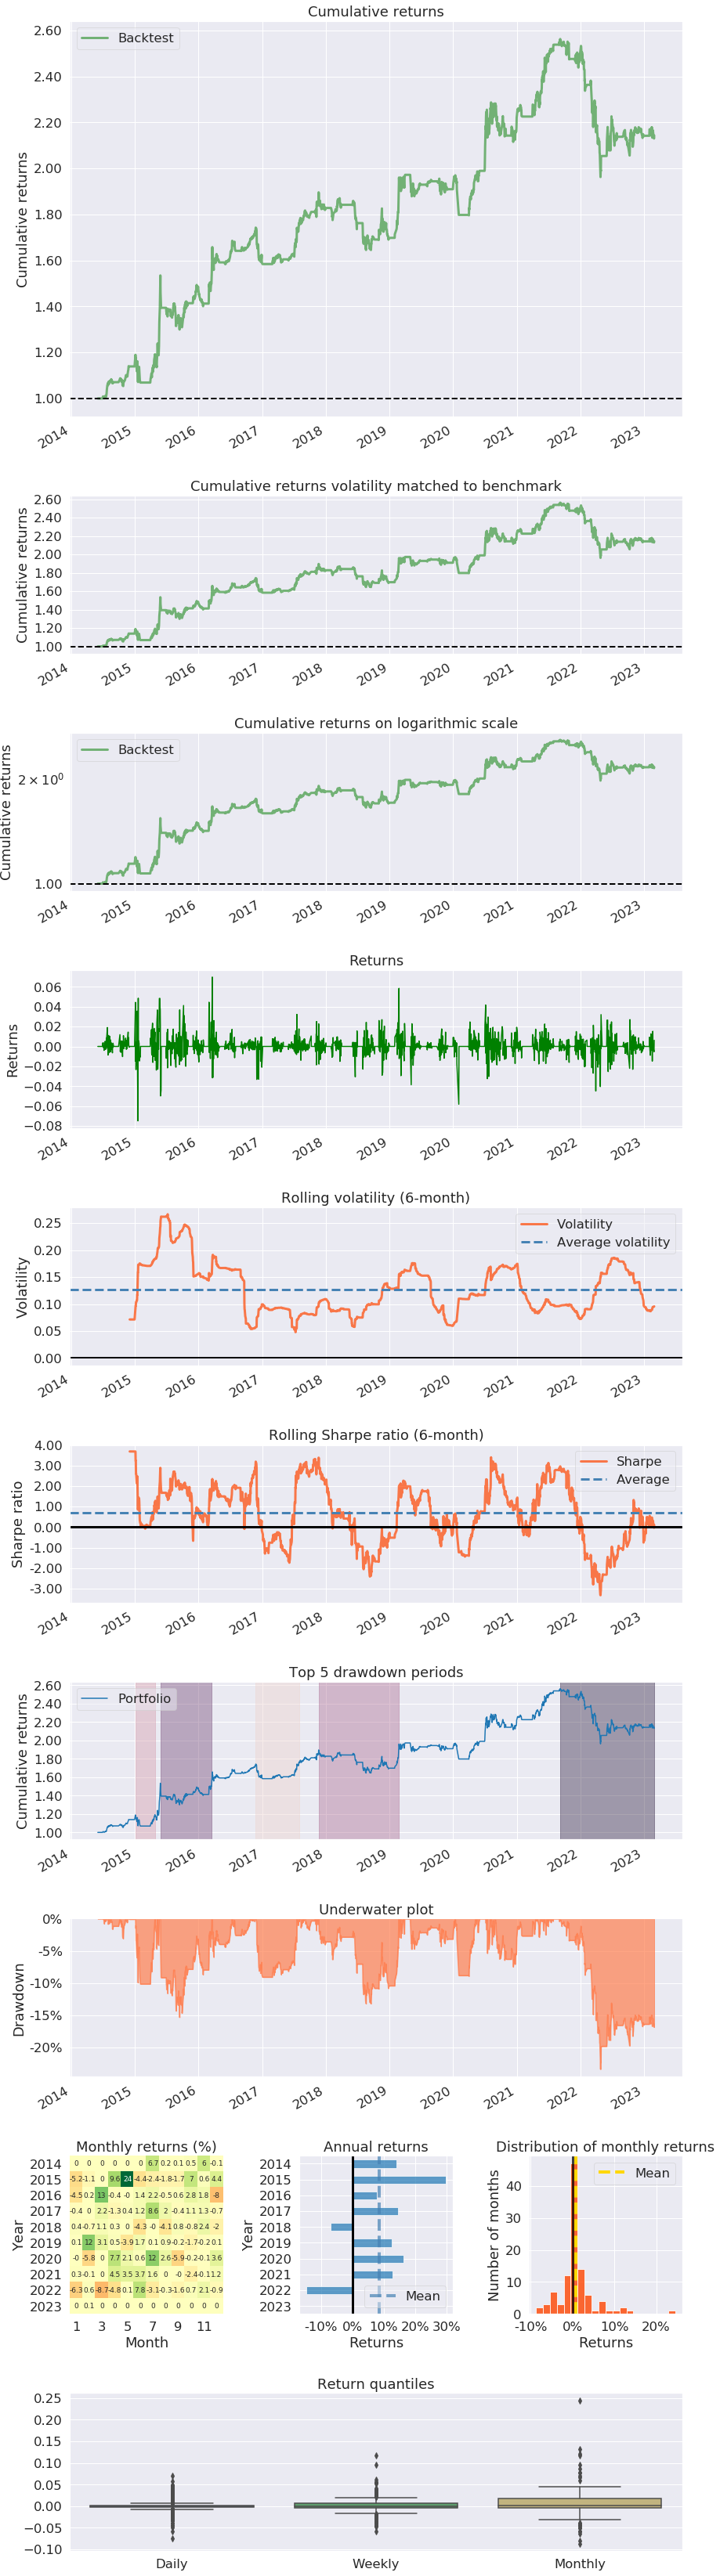

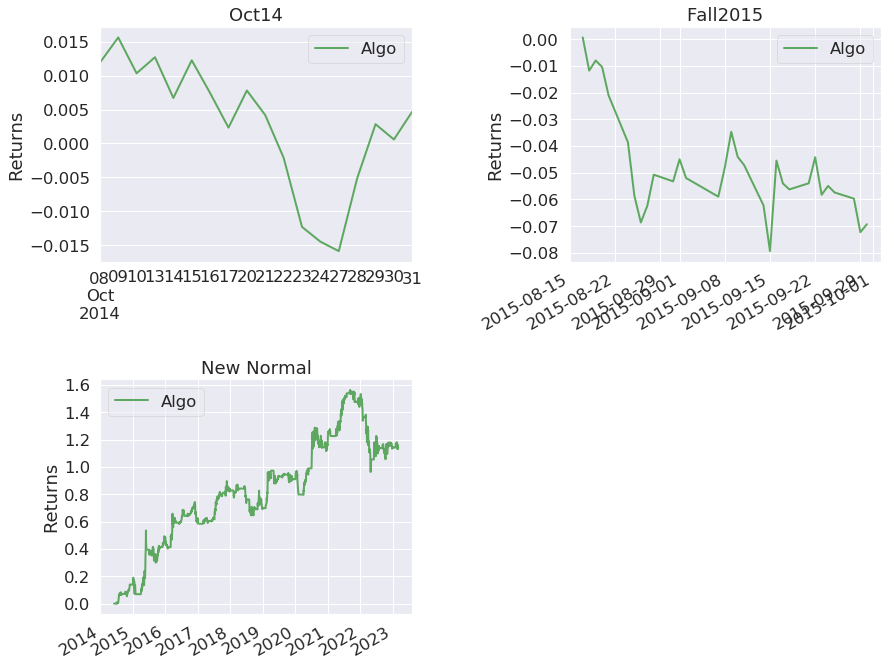

In [12]:
%%capture --no-display
pf.create_full_tear_sheet(returns)

In [13]:
import tushare as ts
def Get_benchmark_kdata(code, start_date, end_date, index=False):
    df = ts.get_k_data(code, autype='qfq', start=start_date, end=end_date, index=index)
    df['date'] = pd.to_datetime(df['date'])
    df['openinterest'] = 0
    return df[['date', 'open', 'high', 'low', 'close', 'volume',  'openinterest']]

In [18]:
import tushare as ts
start_date = '2014-06-30'
end_date = '2023-02-28'
benchmark='000001'
df= Get_benchmark_kdata(benchmark, start_date, end_date,True)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [19]:
df=df.set_index('date')
# 计算收益率
benchmark_rets = df['close'].pct_change()

In [26]:
benchmark_rets = benchmark_rets.rename('SZIndex')

In [27]:
benchmark_rets

date
2014-06-30 00:00:00+00:00         NaN
2014-07-01 00:00:00+00:00    0.001001
2014-07-02 00:00:00+00:00    0.004409
2014-07-03 00:00:00+00:00    0.001850
2014-07-04 00:00:00+00:00   -0.001866
                               ...   
2023-02-22 00:00:00+00:00   -0.004648
2023-02-23 00:00:00+00:00   -0.001115
2023-02-24 00:00:00+00:00   -0.006181
2023-02-27 00:00:00+00:00   -0.002794
2023-02-28 00:00:00+00:00    0.006624
Name: SZIndex, Length: 2110, dtype: float64

Start date,2014-06-30
End date,2023-02-28
Total months,100
,Backtest
Annual return,9.5%
Cumulative returns,114.4%
Annual volatility,13.4%
Sharpe ratio,0.75
Calmar ratio,0.41
Stability,0.83
Max drawdown,-23.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.41,2021-09-07,2022-04-26,NaT,NaN
1,15.34,2015-05-28,2015-09-15,2016-03-18,212
2,13.22,2017-11-21,2018-09-17,2019-02-25,330
3,10.15,2015-01-05,2015-02-02,2015-04-27,81
4,9.09,2016-11-25,2017-01-03,2017-07-31,177


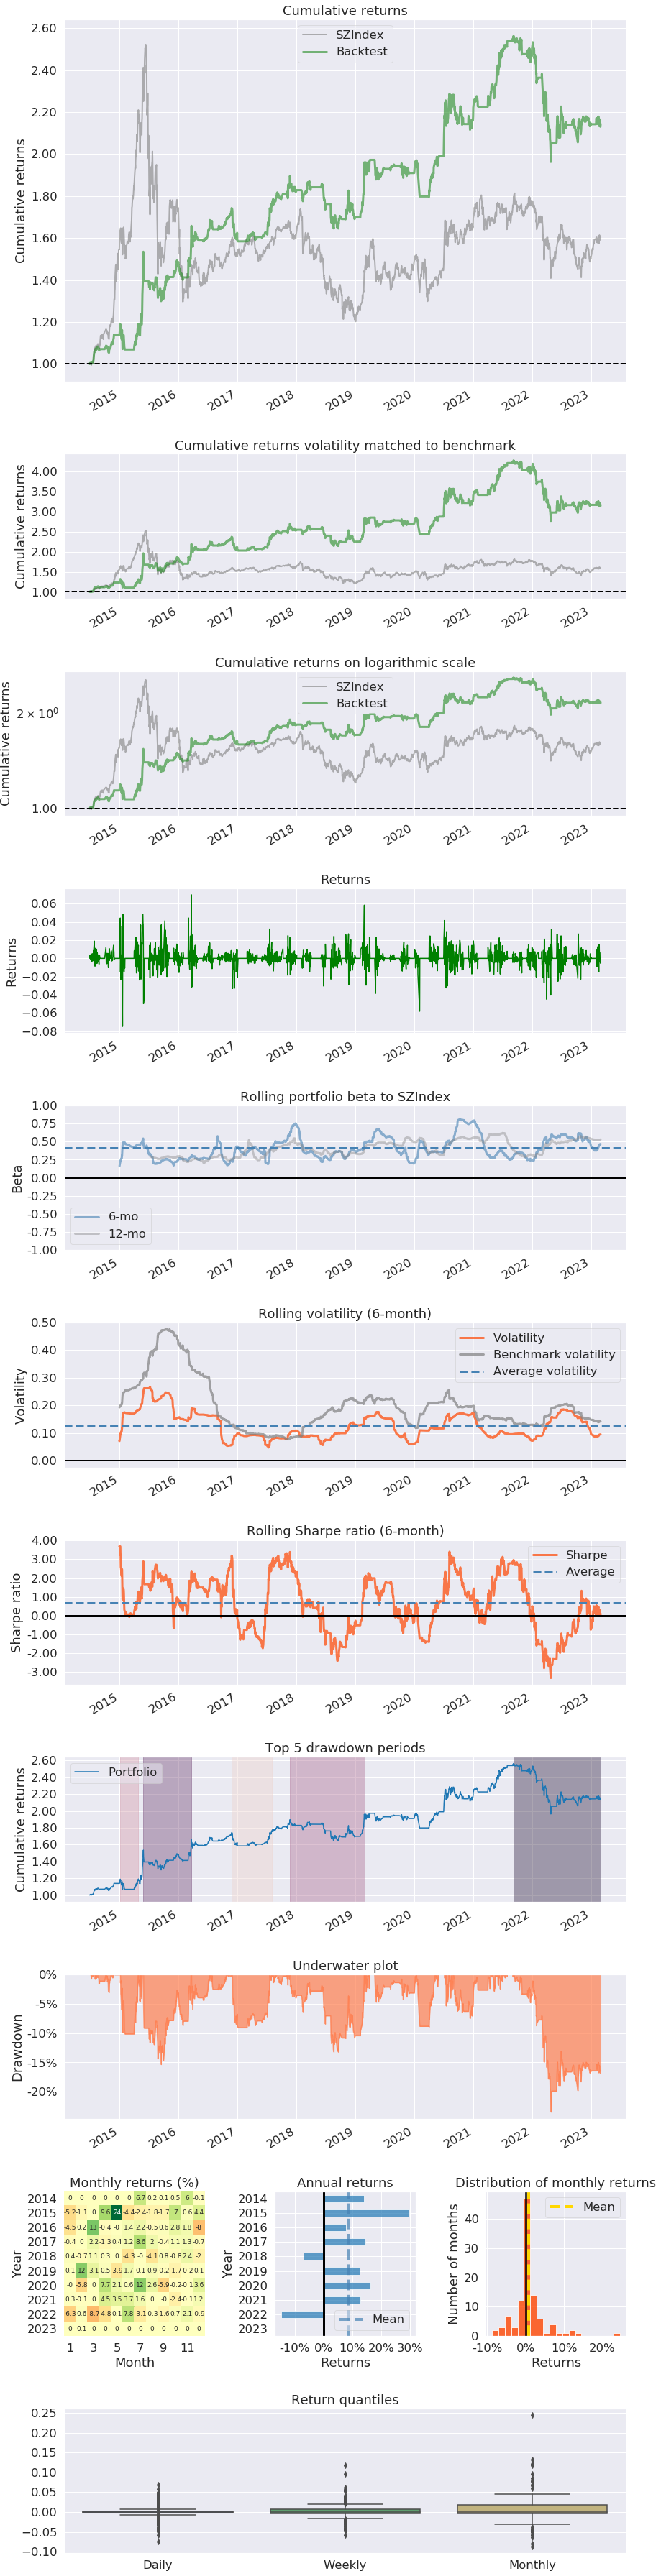

In [28]:
# benchmark_rets = benchmark_rets.tz_localize('UTC')
pf.create_returns_tear_sheet(returns, benchmark_rets=benchmark_rets)